# The Bayesian framework

In [1]:
from scipy import optimize
from scipy.interpolate import interp1d
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# load the filename list
#fns = glob.glob('../../Data/LUT/lhd300_validate_ap/20/30/45/*.p')
fns = ['../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p']

print 'loading file: %s' % fns[0]

wl_min = 680.
wl_max = 755.


loading file: ../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p


solver success: True
cost: 162.0813
sza: 21.0, vza: 15.0, raa: 19.0, alt: 0.50970436 km
--------------------------------------------------
True parameters
clf: 0.3000, AOT: 0.0723, WVC: 16.3794 kg/m2, press: 1001.9963 hPa, a: 0.3666, p: 0.6247, DASF: 0.9767
--------------------------------------------------
Prior parameters (mean, std)
clf: 0.2500, AOT: 0.1000, WVC: 20.0000 kg/m2, press: 1000.0000 hPa
std: 0.0500, std: 0.0500, std:  3.0000 kg/m2, std:      5.0000 hPa
--------------------------------------------------
Retrieved parameters (mean, std)
clf: 0.6883, AOT: 0.1160, WVC: 20.2473 kg/m2, press: 1003.6448 hPa, a: 0.8287, p: 0.5982, DASF: 2.0624
std:   nan, std: 0.0355, std:     nan kg/m2, std:      3.5164 hPa,std:  nan,std:0.0020
--------------------------------------------------
Correlation matrix
[[ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan 

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:131: OptimizeWarning: Unknown solver options: upper, lower


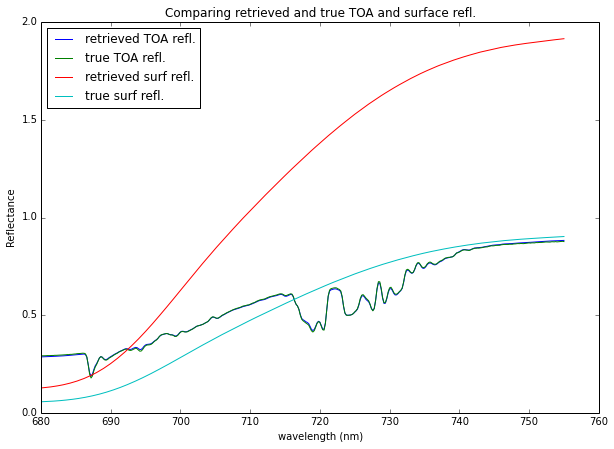

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


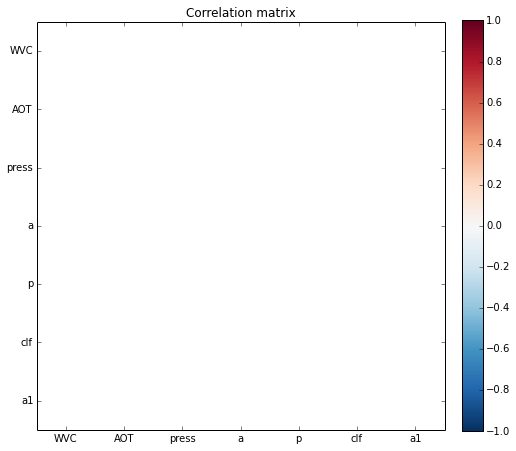

In [30]:
dic = pickle.load(open(fns[0], 'rb'))

# cloud fraction to use
clf = 0.3

# priors variances are based on the following:
# MODIS AOD +-0.05 +-0.2*tau (Chu et al. 2002)
# MODIS WV std 2.2mm (Li, Muller & Cross, 2003)
# NCEP press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)


AOT_prior = 0.10
AOT_var = (0.05)**2
WVC_prior = 20.
WVC_var = (3.0)**2
press_prior = 1000.
press_var = (5.0)**2
clf_prior = 0.25
clf_var = (0.05)**2

# round to closest value
sza = dic['sol_zen']
vza = dic['sat_zen']
raa = dic['rel_azi']
alt = dic['alt']
AOT = dic['AOT']
WVC = dic['WVC']
press = dic['press']
a = dic['a']
p = dic['p']
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))
toa_refl = dic['toa_refl']
lam = dic['lam']
lam_emu = lam[np.logical_and(lam>=680., lam<=755.)]

# get wavelength interval to approximately GOME-2 resolution
resol = 0.2 # in nm
lam_gome = np.arange(wl_min, wl_max+0.001, resol)
lam_gome[-1] = np.round(lam_gome[-1], 2) # get rid of precision error

# adding clouds
import pandas as pd
fn = 'cloud_sims.h5'
cld_type = 'Cu'
cld_df = pd.read_hdf(fn, key='reflectance')
cld_lam = cld_df[cld_type].icol(0).index.values
cld_ref = cld_df[cld_type].icol(0).values
cld_ref = (interp1d(cld_lam, cld_ref, kind='linear'))(lam_gome)

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources above
std_noise = cld_ref / snr
rand_noise = np.random.normal(0., std_noise)
cld_ref += rand_noise

# refl to gome
toa_refl_gome = (interp1d(lam, toa_refl, kind='linear'))(lam_gome)
std_noise = toa_refl_gome / snr
rand_noise = np.random.normal(0., std_noise)
toa_refl_gome += rand_noise

# combine atmosphere and cloud signal
toa_refl_gome = toa_refl_gome * (1. - clf) + cld_ref * clf

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas = pca_red_df.values.T

# interpolate to gome resolution
# pcas = []
# for pc in pcas_:
#     pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam_gome))
# pcas = np.array(pcas)

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators_680-755.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
basis = emu.basis_functions

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]
mean_toa_refl = mean_toa_refl[np.logical_and(lam>=wl_min, lam<=wl_max)]

def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
         presse, pressv, clfe, clfv):
    '''The cost function to minimize the log of the probabilities
    '''
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    clf = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] # + mean_toa_refl
    toa_refl_pred = toa_refl_emu + mean_toa_refl
    # get refls to same wavelenghts
    from scipy.interpolate import interp1d
    toa_refl_gome = (interp1d(lam_gome, toa_refl_gome, kind='linear'))(lam_emu)
    a0 = 1. / (1. - clf)
    toa_refl_pred = 1. / a0 * (toa_refl_emu - a1 * pcas[0])
    # forward model J term. need to calculate variance
    modvar = (toa_refl_gome/snr)**2.
    Jmod = np.sum((toa_refl_pred - toa_refl_gome)**2./modvar)/len(toa_refl_pred)
    # WVC J term
    Jwvc = (WVC - WVCe)**2./WVCv
    # AOT J term
    Jaot = (AOT - AOTe)**2./AOTv
    # press J term
    Jpress = (press - presse)**2./pressv
    # clf J term
    Jclf = (clf - clfe)**2./clfv
    J = Jmod + Jwvc + Jaot + Jpress + Jclf
    return J

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, clf_prior, clf_var)
#guess = (36., 0.5, 770., 0.4, 0.4, 1.1, 30.) # wvc, aot, press, a, p, clf, a1
guess = (WVC_prior, AOT_prior, press_prior, 0.5, 0.5, clf_prior, 30.)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (0., 10000))
lower = (0., 0., 500., 0., 0., 1., 0.)
upper = (80., 1., 1100., 1., 1., 1000., 10000.)
solv_paras = optimize.minimize(cost,guess,jac=False,method='L-BFGS-B',\
                                args=args,bounds=bounds, options={'lower': lower, 'upper': upper, 'maxiter': 1000})  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
clfr = solv_paras['x'][5]
a0r = 1. / (1. - clfr)
a1r = solv_paras['x'][6]
err = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda a, p, w: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

# calculate the Hessian for the std of the posterior 
import numdifftools as nd
hes = nd.Hessian(cost, full_output=True)
x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, clf_prior, clf_var)
H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, clf_prior, clf_var)
Cov = np.linalg.inv(H[0])
post_std = np.sqrt(np.diag(Cov))
WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

# calculate the correlation matrix
D = np.eye(7)*np.sqrt ( Cov.diagonal() )
R = np.linalg.inv ( D )
corr =  R.dot(Cov.dot(R))

print 'solver success: %s' % succ
print 'cost: %.4f' % err
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'True parameters'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
        (clf, AOT, WVC, press, a, p, dasf_true)
print '-'*50
print 'Prior parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa' % \
        (clf_prior, AOT_prior, WVC_prior, press_prior,)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa' % \
        (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var))
print '-'*50
print 'Retrieved parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:%5.4f,std:%5.4f' % \
        (clfs, AOTs, WVCs, presss, ass, ps )
print '-'*50
#print solv_paras

# plot the spectra true and retrieved
toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl
toa_refl_pred = (interp1d(lam_emu, toa_refl_pred, kind='linear'))(lam_gome)
toa_refl_pred = 1. / a0r * (toa_refl_pred - a1r * pcas[0])
plt.figure(figsize=(10,7))
plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(ar, pr, w)
surf_refl = surf_refl_fun(a, p, w)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

# plot the correlation matrix and print values
plt.figure(figsize=(8,8))
plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
plt.title('Correlation matrix')
plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.colorbar(fraction=0.046, pad=0.04)
print 'Correlation matrix'
print corr

In [32]:
emu.basis_functions.shape

(8, 1501)

In [34]:
emu.emulators

[<gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc368cf8>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc368a70>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc368170>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc359d40>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc359cb0>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc359fc8>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc359f80>,
 <gp_emulator.GaussianProcess.GaussianProcess instance at 0x7fc1bc359f38>]

In [35]:
pca_lam.shape

(1501,)